# Deep Learning Models for Artifact Detection in ONT Long-Read Sequencing WGS Data

Fit several models

- simple logistic regression
- simple MLP
- MLP + dropout
- 2-layer MLP + dropout
- CNN
- LSTM

In [1]:
# imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Bidirectional

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import gc

tf.config.list_physical_devices()

2023-12-11 20:38:10.366133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
# Load data from the npz file
data = np.load('231117_encoded_seqs_labels_int8.npz')
sequences = data['encoded_sequences']
labels = data['input_labels']

sequences.shape, labels.shape

((3504292, 201, 4), (3504292, 2))

In [3]:
# How many items per class?
from collections import Counter

# numpy arrays to tuples
labels_tuples = [tuple(label) for label in labels]

# Calculate the counts using Counter
label_counts = Counter(labels_tuples)
print(label_counts)

# Calculate the proportions
proportions = [count / sum(label_counts.values()) for count in label_counts.values()]
print(proportions)

Counter({(1, 0): 2913229, (0, 1): 591063})
[0.8313316926785782, 0.16866830732142185]


Dataset has ~83.13% true variants and the rest artifacts

## Simple binary logistic regression

In [4]:
# uncompiled model
def create_uncompiled_model():
    tf.keras.backend.clear_session()
    gc.collect()
    
    tf.random.set_seed(42)

    # create model
    model = Sequential([
        Input(shape=(201, 4)), # see sequences.shape
        Flatten(), 
        Dense(2, activation='softmax')
    ])

    model.summary()
    
    return model

# create uncompiled model
lr_model = create_uncompiled_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 804)               0         
                                                                 
 dense (Dense)               (None, 2)                 1610      
                                                                 
Total params: 1,610
Trainable params: 1,610
Non-trainable params: 0
_________________________________________________________________


2023-12-11 20:38:50.015838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 20:38:51.020936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10777 MB memory:  -> device: 0, name: Tesla K40m, pci bus id: 0000:05:00.0, compute capability: 3.5
2023-12-11 20:38:51.022000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10777 MB memory:  -> device: 1, name: Tesla K40m, pci bus id: 0000:81:00.0, compute capability: 3.5


In [5]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    min_delta=0.0001,         # Minimum change to be considered an improvement
    patience=100,              # Number of epochs with no improvement before stopping
    mode='max',               # We want to maximize validation accuracy
    verbose=1                 # Print a message when training stops
)

# compile model
lr_model.compile(optimizer=Adam(learning_rate=1e-3), 
                 loss='binary_crossentropy', 
                 metrics='accuracy')

# Fit the model
epochs = 1000
batch_size = 2**12
history = lr_model.fit(sequences, labels, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[early_stopping],  # Include the EarlyStopping callback
                    validation_split=0.2)  # tunable hyperparameters: batch size and epochs

Epoch 1/1000
685/685 [==============================] - 6s 7ms/step - loss: 0.4445 - accuracy: 0.8311 - val_loss: 0.4309 - val_accuracy: 0.8311
Epoch 2/1000
685/685 [==============================] - 4s 6ms/step - loss: 0.4301 - accuracy: 0.8320 - val_loss: 0.4316 - val_accuracy: 0.8312
Epoch 3/1000
685/685 [==============================] - 4s 7ms/step - loss: 0.4302 - accuracy: 0.8321 - val_loss: 0.4305 - val_accuracy: 0.8315
Epoch 4/1000
685/685 [==============================] - 4s 6ms/step - loss: 0.4302 - accuracy: 0.8321 - val_loss: 0.4305 - val_accuracy: 0.8315
Epoch 5/1000
685/685 [==============================] - 4s 6ms/step - loss: 0.4302 - accuracy: 0.8321 - val_loss: 0.4305 - val_accuracy: 0.8315
Epoch 6/1000
685/685 [==============================] - 4s 6ms/step - loss: 0.4302 - accuracy: 0.8321 - val_loss: 0.4307 - val_accuracy: 0.8313
Epoch 7/1000
685/685 [==============================] - 4s 6ms/step - loss: 0.4302 - accuracy: 0.8321 - val_loss: 0.4307 - val_accuracy:

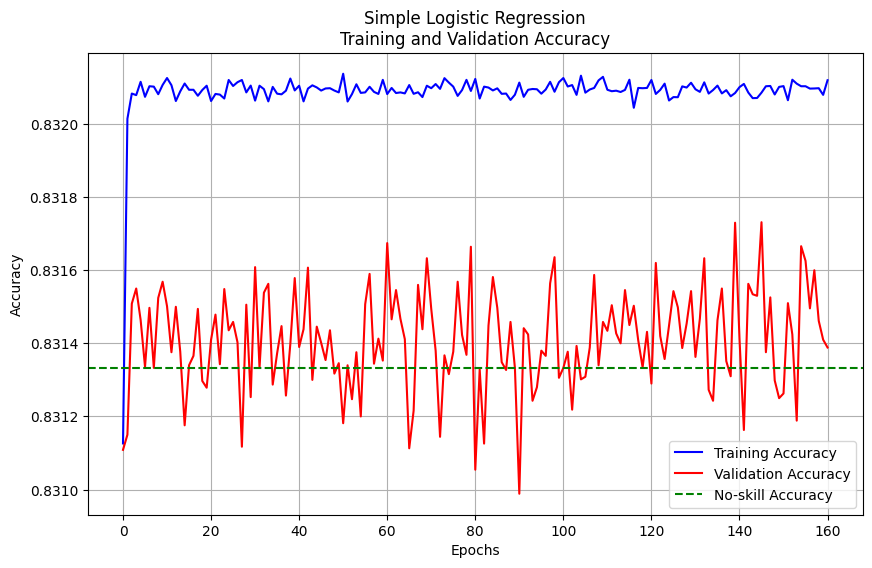

In [6]:
# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Simple Logistic Regression\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-skill Accuracy')

plt.legend()

# Save the figure as an image file
plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')  # 'bbox_inches' to include the whole plot

plt.show()

Simple logistic regression performs about the same as the no-skill classifier based on validation accuracy

---

## basic multilayer perceptron (MLP): 1 hidden layer, 128 nodes

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 804)               0         
                                                                 
 dense (Dense)               (None, 128)               103040    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 103,298
Trainable params: 103,298
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
685/685 [==============================] - 6s 8ms/step - loss: 0.4098 - accuracy: 0.8381 - val_loss: 0.3662 - val_accuracy: 0.8506
Epoch 2/50
685/685 [==============================] - 5s 7ms/step - loss: 0.3442 - accuracy: 0.8626 - val_loss: 0.3350 - val_accuracy: 0.8668
Epoch 3/50
685/685 [==========

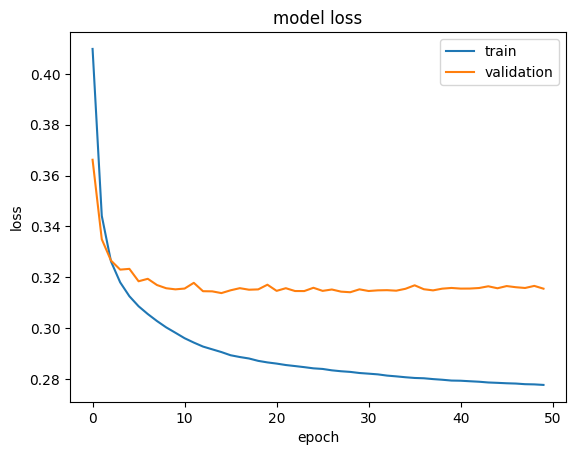

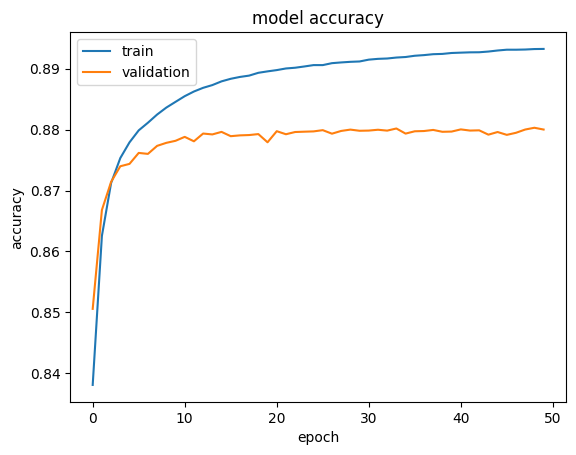

In [7]:
# basic MLP (1 hidden layer, 128 nodes)
tf.keras.backend.clear_session()
gc.collect()

# create model
model = Sequential([
    Input(shape=(201, 4)), 
    Flatten(), 
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model with appropriate loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # tunable hyperparameter: learning rate
              metrics=['accuracy'])

model.summary()

# Fit the model
history = model.fit(sequences, labels, 
                    epochs=50, 
                    batch_size=2**12, 
                    validation_split=0.2)  # tunable hyperparameters: batch size and epochs

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

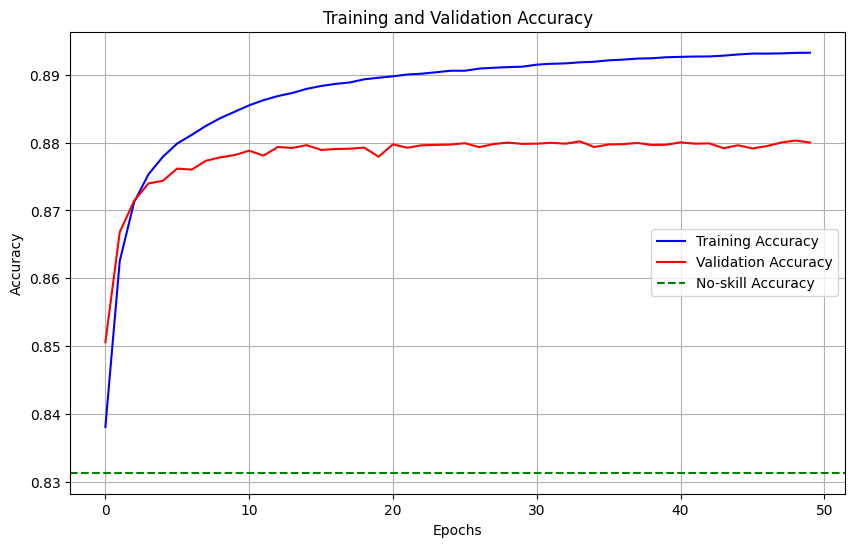

0.8803040385246277

In [8]:
# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-skill Accuracy')

plt.legend()
plt.show()

np.max(history.history['val_accuracy'])

A basic MLP performs much better than the no-skill classifier (accuracy 0.8811 vs 0.8313). However, based on the large divergence between training and validation curves, we have overfitting happening. Let's see if adding dropout mitigates this.

---

## basic MLP (1 hidden layer, 128 nodes) + 20% dropout

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 804)               0         
                                                                 
 dense (Dense)               (None, 128)               103040    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 103,298
Trainable params: 103,298
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
685/685 [==============================] - 6s 8ms/step - loss: 0.4210 - accuracy: 0.8351 - val_loss: 0.3805 - val_accuracy: 0.8446
Epoch 2/50
685/685 [====================

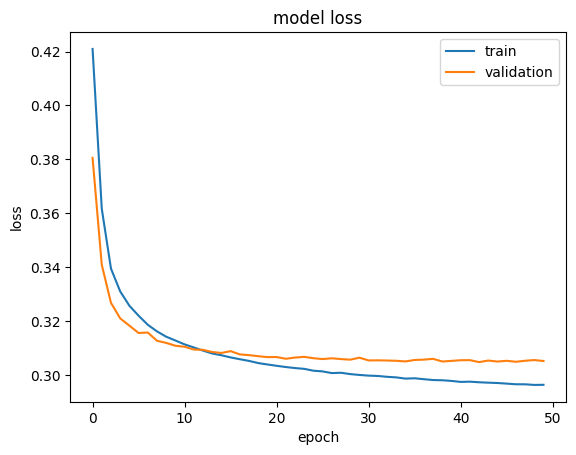

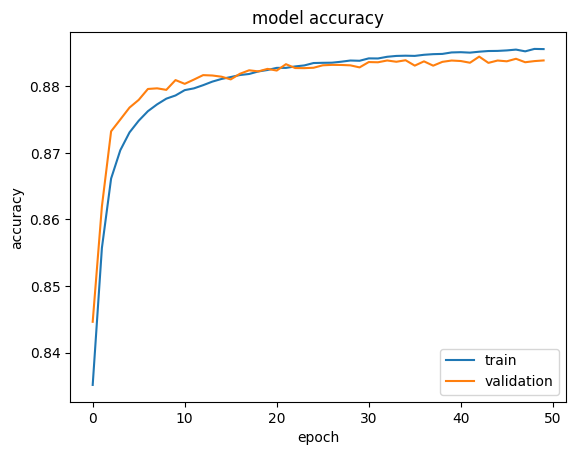

In [9]:
# basic MLP (1 hidden layer, 128 nodes)
tf.keras.backend.clear_session()
gc.collect()

# create model
model = Sequential([
    Input(shape=(201, 4)), 
    Flatten(), 
    Dense(128, activation='relu'), 
    Dropout(0.2), 
    Dense(2, activation='softmax')
])

# Compile the model with appropriate loss and optimizer
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),  # tunable hyperparameter: learning rate
              metrics=['accuracy'])

model.summary()

# Fit the model
history = model.fit(sequences, labels, 
                    epochs=50, 
                    batch_size=2**12, 
                    validation_split=0.2)  # tunable hyperparameters: batch size and epochs



plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Adding droput mitigates the overfitting previously seen and validation accuracy also appears to have improved. Since the validation accuracy is still trending up, increasing the number of training epochs might give us further gains. We submit a SLURM job with 1,000 epochs using EarlyStopping to halt training if no improvement is seen in validation accuracy after 100 epochs.

In [10]:
cat python_scripts/231126_Dense128_Dropout020_01.py

from datetime import datetime
import sys # logging

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
log_file_name = f"logs/231126_Dense128_Dropout020_01_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

import numpy as np
import tensorflow as tf
import gc
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

gc.collect()

# Load data from the npz file
data = np.load('../231117_encoded_seqs_labels_int8.npz')
sequences = data['encoded_sequences']
labels 

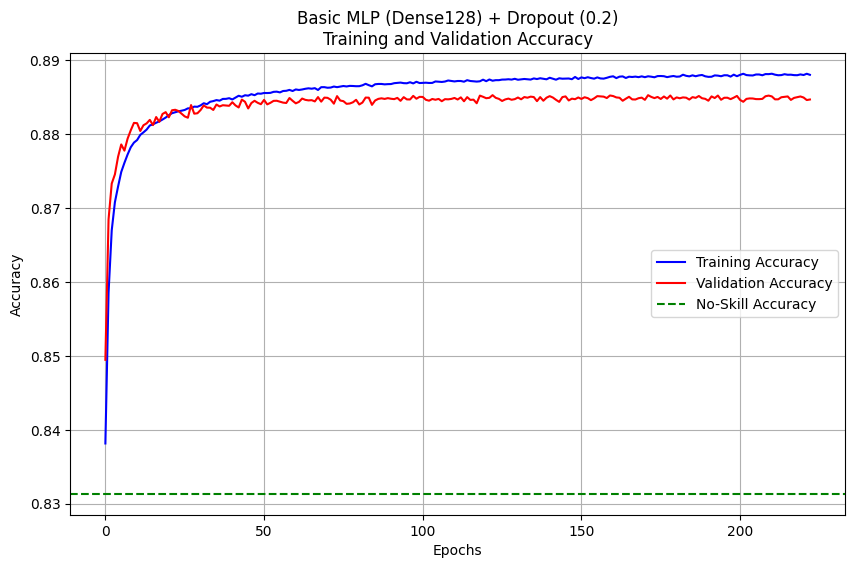

0.8852508068084717

In [11]:
pklfile = "python_scripts/pkls/231126_Dense128_Dropout020_01_20231126_065411.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

import matplotlib.pyplot as plt
# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Basic MLP (Dense128) + Dropout (0.2)\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

np.max(history.history['val_accuracy'])

Adding dropout to the basic MLP improves validation accuracy (0.8811 to 0.8853). Perhaps adding an additional dense layer will give us performance gains?

---

## basic MLP (2 hidden layers, 128 nodes) + 20% dropout

In [12]:
cat python_scripts/231126_Dense128_Dense128_Dropout020_01.py

from datetime import datetime
import sys # logging

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
log_file_name = f"logs/231126_Dense128_Dropout020_01_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

import numpy as np
import tensorflow as tf
import gc
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

gc.collect()

# Load data from the npz file
data = np.load('../231117_encoded_seqs_labels_int8.npz')
sequences = data['encoded_sequences']
labels 

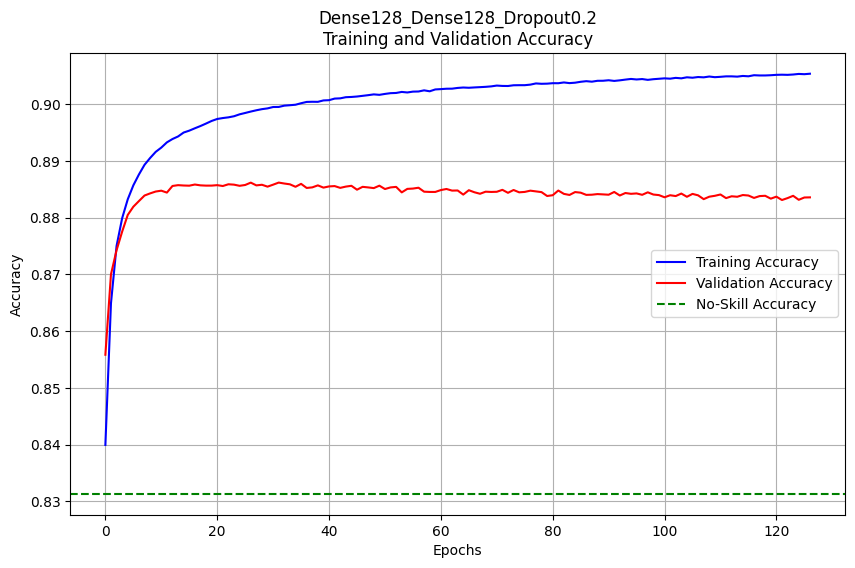

In [13]:
pklfile = "python_scripts/pkls/231126_Dense128_Dropout020_01_20231126_072810.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

import matplotlib.pyplot as plt
# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dense128_Dense128_Dropout0.2\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

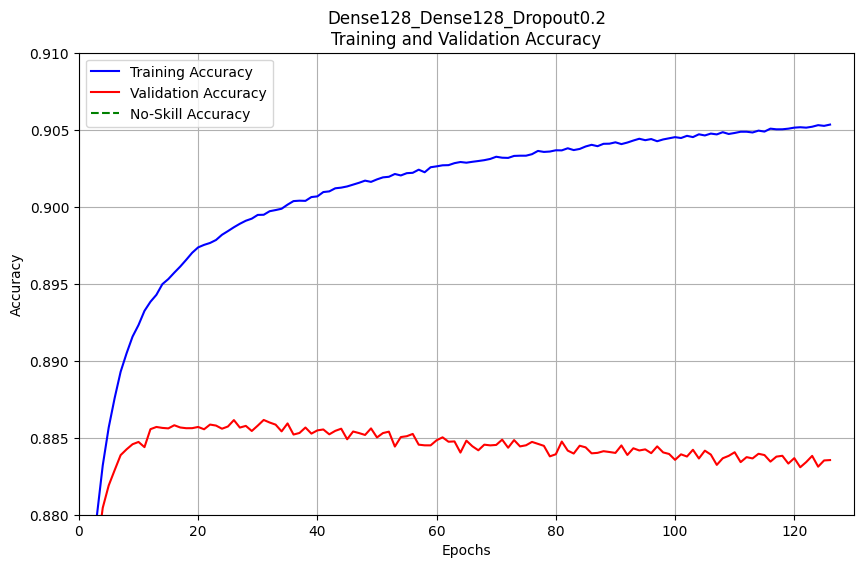

0.8861539959907532

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dense128_Dense128_Dropout0.2\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.axis([0, 130, 0.88, 0.91])
plt.show()

np.max(history.history['val_accuracy'])

Adding another hidden dense layer does improve validation accuracy (0.8862 vs 0.8853) but the 20% dropout layer is no longer sufficient to prevent overfitting. What if we increase the dropout to 40%?

## basic MLP (2 hidden layers, 128 nodes) + 40% dropout

In [15]:
cat python_scripts/231127_Dense128_Dense128_Dropout040_01.py

from datetime import datetime
import sys # logging
import os # basename

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
base_name = os.path.splitext(os.path.basename(__file__))[0]
log_file_name = f"logs/{base_name}_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

import numpy as np
import tensorflow as tf
import gc
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

gc.collect()

# Load data from the npz file
data = np.load('../231117_encoded_seqs_

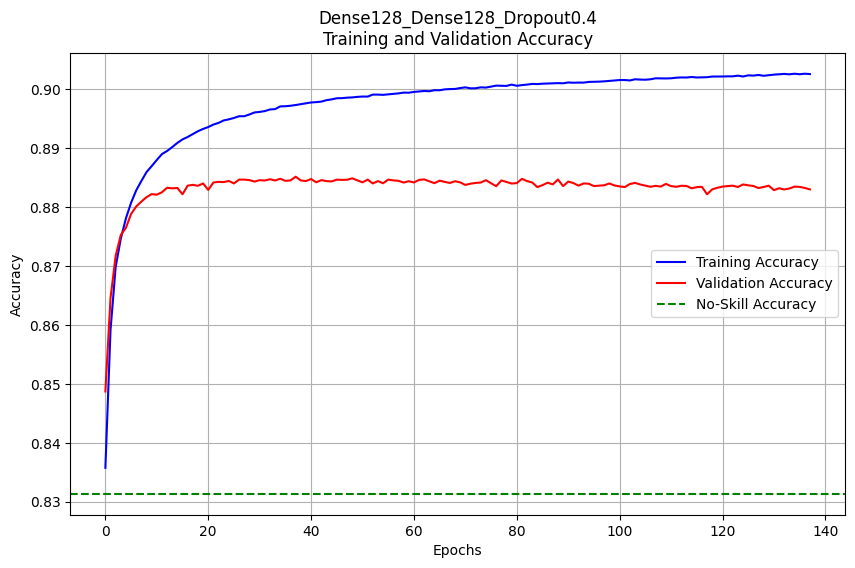

In [16]:
pklfile = "python_scripts/pkls/231127_Dense128_Dense128_Dropout040_01_20231127_051520.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

import matplotlib.pyplot as plt
# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dense128_Dense128_Dropout0.4\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

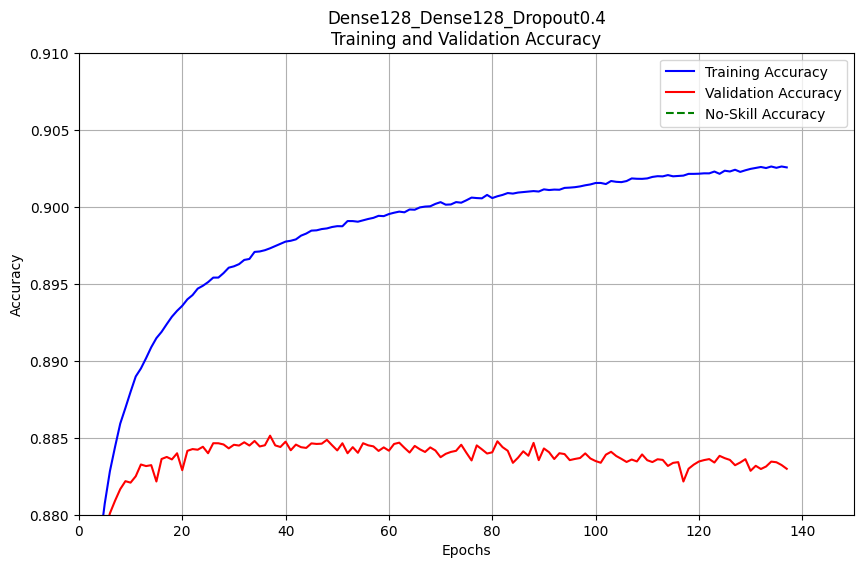

0.8851338028907776

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dense128_Dense128_Dropout0.4\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.axis([0, 150, 0.88, 0.91])
plt.show()

np.max(history.history['val_accuracy'])

We still see overfitting based on downward trend of validation accuracy curve. What if we added another 20% dropout layer between the two dense layers?

## basic MLP + dropout (Dense 128 + 20% Dropout + Dense 128 + 20% Dropout)

In [18]:
cat python_scripts/231127_Dense128_Dropout020_Dense128_Dropout020_01.py

from datetime import datetime
import sys # logging
import os # basename

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
base_name = os.path.splitext(os.path.basename(__file__))[0]
log_file_name = f"logs/{base_name}_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

import numpy as np
import tensorflow as tf
import gc
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

gc.collect()

# Load data from the npz file
data = np.load('../231117_encoded_seqs_

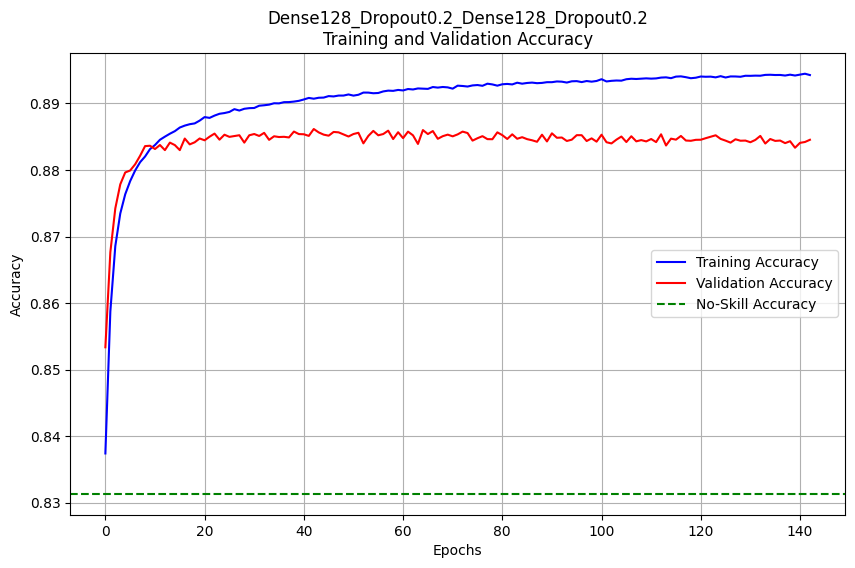

In [19]:
pklfile = "python_scripts/pkls/231127_Dense128_Dropout020_Dense128_Dropout020_01_20231127_052120.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

import matplotlib.pyplot as plt
# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dense128_Dropout0.2_Dense128_Dropout0.2\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

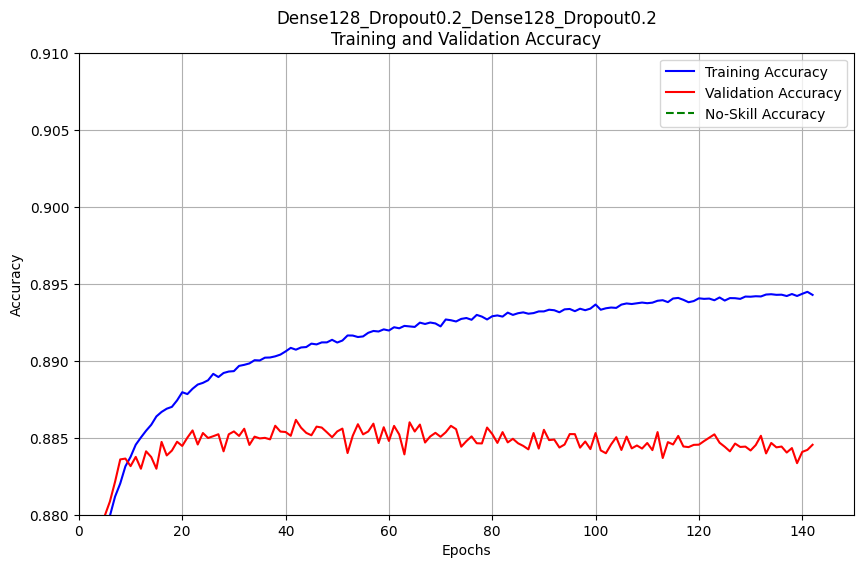

0.8861611485481262

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dense128_Dropout0.2_Dense128_Dropout0.2\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.axis([0, 150, 0.88, 0.91])
plt.show()

np.max(history.history['val_accuracy'])

Still see downward trend of validation accuracy curve. Let's pass the sequences through a convolutional layer before the dense layers to see if that improves performance.

---

## CNN + MLP (Dense128 + 20% Dropout)

In [21]:
cat python_scripts/231129_Conv1D64k5_Dense128_Dropout020_Adam8e-3.py

from datetime import datetime
import sys # logging
import os # basename

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
base_name = os.path.splitext(os.path.basename(__file__))[0] # name of log file should include name of this script
log_file_name = f"logs/{base_name}_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

import numpy as np
import tensorflow as tf
import gc
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.call

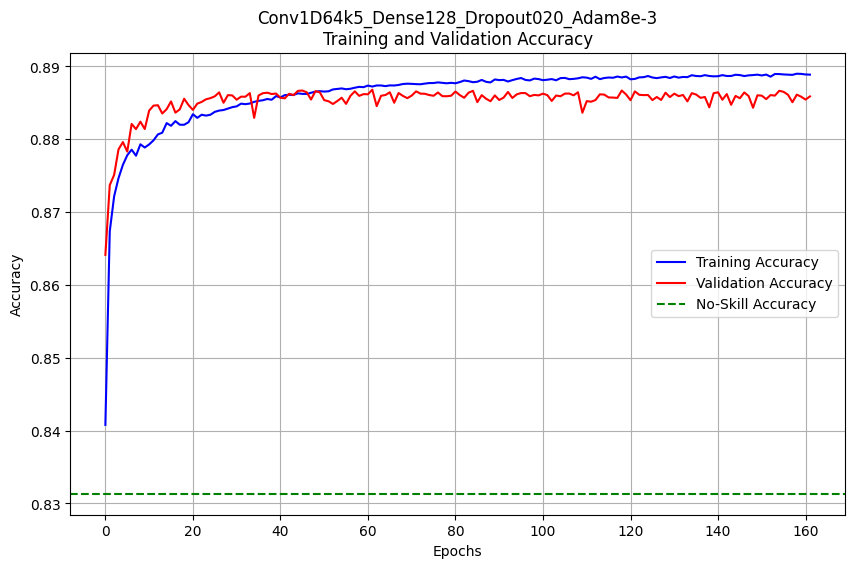

0.8868131637573242

In [22]:
pklfile = "python_scripts/pkls/231129_Conv1D64k5_Dense128_Dropout020_Adam8e-3_20231129_230334.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Conv1D64k5_Dense128_Dropout020_Adam8e-3\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

np.max(history.history['val_accuracy'])

Adding the convolutional layer to the Dense128_Dropout0.2 model improves performance (0.8853 to 0.8868). Will it improve the model with TWO dense layers and 20% dropout as well?

## CNN + MLP (Dense128 + Dense128 + 20% Dropout)

In [23]:
cat python_scripts/231129_Conv1D64k5_Dense128_Dense128_Dropout020_Adam8e-3.py

from datetime import datetime
import sys # logging
import os # basename

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
base_name = os.path.splitext(os.path.basename(__file__))[0] # name of log file should include name of this script
log_file_name = f"logs/{base_name}_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

import numpy as np
import tensorflow as tf
import gc
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.call

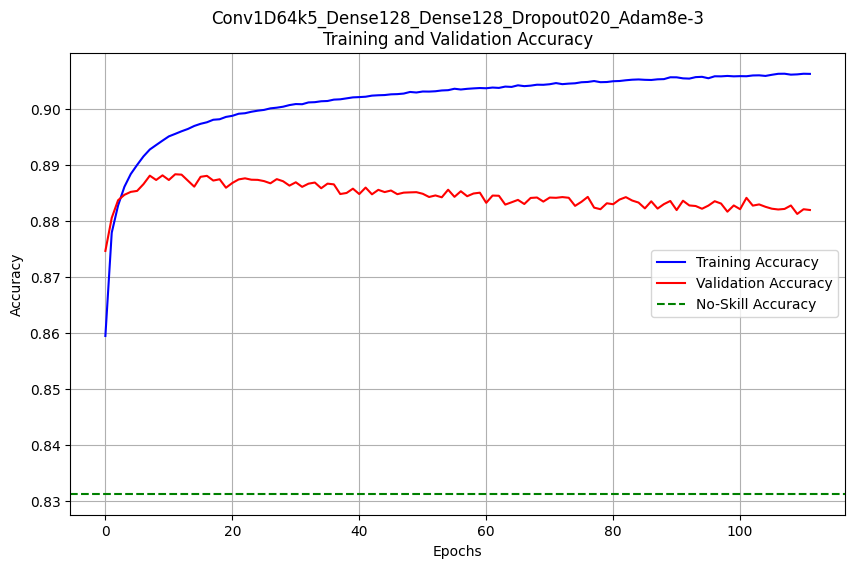

0.8882842063903809

In [24]:
pklfile = "python_scripts/pkls/231129_Conv1D64k5_Dense128_Dense128_Dropout020_Adam8e-3_20231129_223150.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Conv1D64k5_Dense128_Dense128_Dropout020_Adam8e-3\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

np.max(history.history['val_accuracy'])

Adding the convolutional layer to the model with TWO dense layers and 20% dropout also improves performance (0.8862 vs 0.8883). Let's see if recurrent neural network- (RNN-)based architectures improve over the CNN architecture.

## BiLSTM + MLP (Dense128 + Dense128 + 20% Dropout)

In [25]:
cat python_scripts/231107_BiLSTM64_2xDense128_Dropout020_Adam1e-4.py

from datetime import datetime
import sys # logging
import os # basename

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

# Open a text file for writing output of all print statements and stderr
base_name = os.path.splitext(os.path.basename(__file__))[0] # name of log file should include name of this script
log_file_name = f"logs/{base_name}_{current_time}.log"
log_file = open(log_file_name, 'w')

# Redirect both standard output and standard error to the log file
sys.stdout = log_file
sys.stderr = log_file

#######################################################################################################################################

# imports
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Bidirectional

from tensorflow.keras.optimizers import Adam
fr

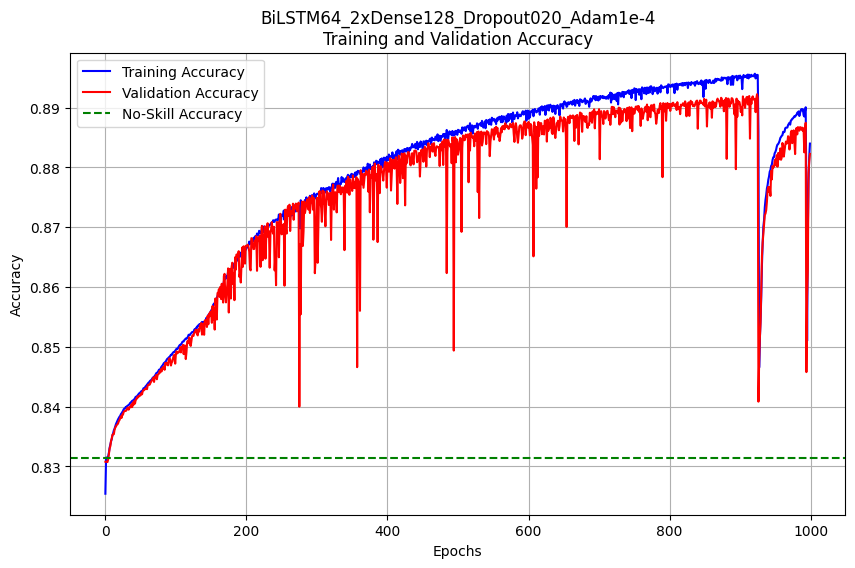

0.8922279477119446

In [26]:
pklfile = "python_scripts/pkls/231107_BiLSTM64_2xDense128_Dropout020_Adam1e-4_20231207_173318.pkl"
with open(pklfile, 'rb') as file:
    history = pickle.load(file)

# Plot training accuracy and validation accuracy vs no-skill classifier
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BiLSTM64_2xDense128_Dropout020_Adam1e-4\nTraining and Validation Accuracy')
plt.grid(True)

# Add a horizontal dashed line at y = 0.8313
plt.axhline(y=0.8313316926785782, color='green', linestyle='--', label='No-Skill Accuracy')

plt.legend()
plt.show()

np.max(history.history['val_accuracy'])

Using a bidirectional LSTM layer instead of a convolutional layer improves the validation accuracy (0.8922 vs 0.8882). However, the training is extremely unstable as can be seen in the oscillations in the accuracy curves, particularly the validation accuracy curve. We can try and address this using batch normalization and with larger batch sizes.

---

## NEXT:

- add `BatchNormalization` to the model to try improving stability of training
- increase batch size to try improving stability of training
- explore stacking two biLSTM layers to improve accuracy